# Introduction/Business problem
The New York metropolitan area is home to the largest and most prominent ethnic Chinese population outside of Asia. New York City itself contains by far the highest ethnic Chinese population of any individual city outside Asia, estimated at 628,763 as of 2017. Between 2000 and 2015, the population of foreign-born Chinese people in NYC grew by nearly 50 percent, the second-fastest-growing immigrant group, according to government data. At New York University alone, the population of Chinese international students more than doubled between 2012 and 2016, something that’s already impacted the East Village dining scene. New York City is experiencing a Chinese food renaissance. Never before have the city’s offerings been so diverse; not only are multiple regions represented, but price points range, too. A huge audience of discerning Chinese expats who seek flavors from home is fueling a highly competitive market of contemporary regional Chinese restaurants — one that means all of New York has access to a restaurant scene that’s better than it’s ever been. Despite the fact that the COVID-19 pandemic is far from over, chinese restaurants have reopened faster than any other category of independent restaurant. On March 30, 94% of Chinese restaurants were closed, compared with 61% of the city’s other restaurants. By June 20, the number of closures had fallen to 10%. As follows from the above, New York City attracts many to start their business in the Chinese food industry. Before opening your business, you need to correctly determine the location, for which you need to analyze the situation with existing restaurants, their specifics and ratings in different areas of New York.

# Data

For this project we need the following data :

New York City data that contains list of Boroughs, Neighborhoods along with their latitude and longitude. Data source : https://cocl.us/new_york_dataset. This data set contains the required information which we will use to explore various neighborhoods of New York city. It may be necessary to trim the data and reduce it to boroughs of NYC.

Chinese restaurants in each neighborhood of New York city. Data source : Fousquare API By using this API we will get the most common venues of given Borough of New York City. We can filter these venues to get only Chinese restaurants.

Getting Coordinates of Boroughs. Data source: Geopy Client Next objective is to get the coordinates of the major districts using geocoder class of Geopy.

Using Foursquare API to get the venues' record of given venues of New York City. To find rating , tips and like count for each Chinese restaurant, using rating for each restaurant, we will sort that data.

## Approach

Collect the new york city data from https://cocl.us/new_york_dataset
Using FourSquare API we will find all venues for each neighborhood.
Filter out all venues that are Chinese Resturants.
Find rating , tips and like count for each Indian Resturants using FourSquare API.
Using rating for each resturant , we will sort that data.
Visualize the Ranking of neighborhoods using folium library(python)


## Analysis
We will import the required libraries for python.
pandas and numpy for handling data.
request module for using FourSquare API.
geopy to get co-ordinates of City of New York.
folium to visualize the results on a map

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from urllib.request import urlopen

!pip install bs4
from bs4 import BeautifulSoup

!conda config --add channels conda-forge

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

!conda install -c conda-forge geocoder --yes
import geocoder
import os

!conda install -c conda-forge folium --yes
import folium # map rendering library
 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('Libraries imported.')

     |████████████████████████████████| 122kB 6.5MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda

Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [3]:
 def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'XXNEZB1OBELFJWEI0RC3CA5FVFQEAUJPEPACBB5CTT1WRBE1'
    CLIENT_SECRET = '1S420RUZSANGPT1TFHEJ1GPMR1KFAU4OVQMOI0XEUG52LN5C'
    VERSION = '20180605' 
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df    

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [4]:
def get_venue_details(venue_id): 
    
    CLIENT_ID = 'XXNEZB1OBELFJWEI0RC3CA5FVFQEAUJPEPACBB5CTT1WRBE1'
    CLIENT_SECRET = '1S420RUZSANGPT1TFHEJ1GPMR1KFAU4OVQMOI0XEUG52LN5C'
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [5]:
    
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [6]:
new_york_data=get_new_york_data()
new_york_data.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


In [7]:
new_york_data.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York

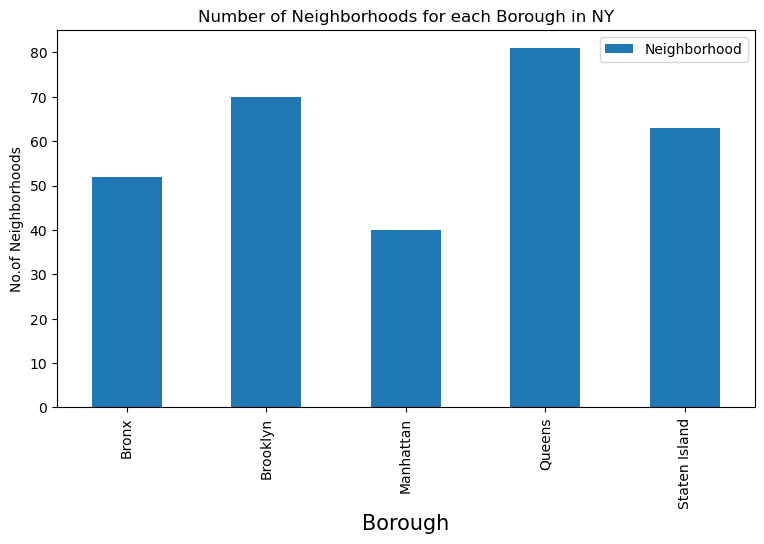

In [8]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhoods for each Borough in NY')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhoods', fontsize=10)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

Now we will collect Chinese resturants for each Neighborhood

In [9]:
# prepare neighborhood list that contains chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Chinese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(chinese_resturants)))
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Chinese Restaurants in Wakefield, Bronx:1
( 2 / 306 ) Chinese Restaurants in Co-op City, Bronx:1
( 3 / 306 ) Chinese Restaurants in Eastchester, Bronx:0
( 4 / 306 ) Chinese Restaurants in Fieldston, Bronx:1
( 5 / 306 ) Chinese Restaurants in Riverdale, Bronx:0
( 6 / 306 ) Chinese Restaurants in Kingsbridge, Bronx:0
( 7 / 306 ) Chinese Restaurants in Marble Hill, Manhattan:1
( 8 / 306 ) Chinese Restaurants in Woodlawn, Bronx:0
( 9 / 306 ) Chinese Restaurants in Norwood, Bronx:3
( 10 / 306 ) Chinese Restaurants in Williamsbridge, Bronx:0
( 11 / 306 ) Chinese Restaurants in Baychester, Bronx:2
( 12 / 306 ) Chinese Restaurants in Pelham Parkway, Bronx:3
( 13 / 306 ) Chinese Restaurants in City Island, Bronx:1
( 14 / 306 ) Chinese Restaurants in Bedford Park, Bronx:2
( 15 / 306 ) Chinese Restaurants in University Heights, Bronx:0
( 16 / 306 ) Chinese Restaurants in Morris Heights, Bronx:2
( 17 / 306 ) Chinese Restaurants in Fordham, Bronx:1
( 18 / 306 ) Chinese Restaurants in Ea

Now that we have got all the chinese resturants in new york city , we will analyze it

In [10]:
chinese_rest_ny.head(10)

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4edbac4e775bcc53fc0ed5f8,Hong Kong China King
1,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet
2,Bronx,Fieldston,4f5543a7e4b0ac8e5378b9de,Broadway Chinese Kitchen
3,Manhattan,Marble Hill,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant
4,Bronx,Norwood,4e2e08021838f1c552b6b8eb,Choi Yuan - Chinese Restaurant
5,Bronx,Norwood,4e4d0387bd413c4cc66dfd72,Hung Hing Chinese Restaurant
6,Bronx,Norwood,4e6aa73eaeb7c31e43294be9,Sing Fei Chinese Restaurant
7,Bronx,Baychester,4c1a8bac8b3aa593a8c8955f,Dragon City
8,Bronx,Baychester,4e4df7a7bd4101d0d79f46f2,Golden Star Garden
9,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant


In [11]:
chinese_rest_ny.shape

(389, 4)

We got 389 Chinese Resturants across New York City

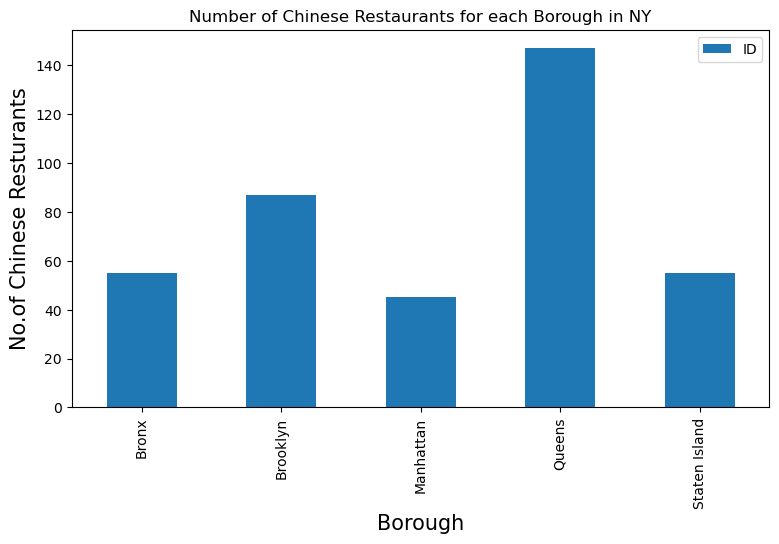

In [12]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Restaurants for each Borough in NY')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=15)
#giving a bar plot
chinese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has the largest number of chinese restaurants

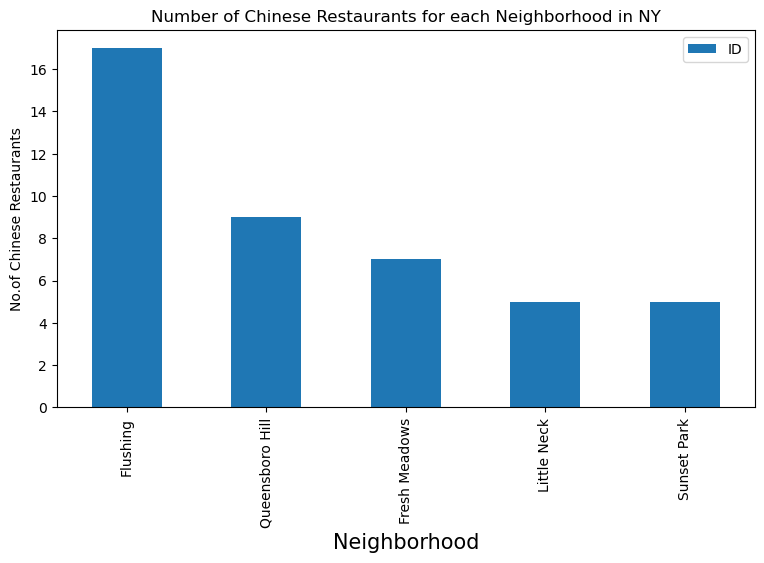

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Restaurants for each Neighborhood in NY')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Restaurants', fontsize=10)
#giving a bar plot
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [14]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Flushing']

,Borough,Neighborhood,ID,Name
162,Queens,Flushing,5747a89b498ee4b7a5106556,DunHuang Lanzhou Beef Noodle
163,Queens,Flushing,4fa3f81be4b0a34ac673bf1e,Taipei Hong 台北夯
164,Queens,Flushing,52235ea211d2fe55782d764c,Dong Yi Feng
165,Queens,Flushing,4ad50f59f964a520950121e3,Fu Run 賦潤東北美食
166,Queens,Flushing,4c78756397028cfaec16d8fe,New Golden Szechuan Chinese Restaurant
167,Queens,Flushing,4faff7eae4b03b8055801cde,Xi'an Famous Foods
168,Queens,Flushing,4a1845c8f964a52092791fe3,Asian Jewels Seafood Restaurant 敦城海鲜酒家
169,Queens,Flushing,4abfef82f964a520179320e3,New Imperial Palace 東湖
170,Queens,Flushing,4d1bcddc1356224bc6410abe,OK Ryan
171,Queens,Flushing,4ef37491d3e32dc398c7c5c7,Laoma Mala Tang


So Flushing in Queens has the highest number of Chinese Resturants with a total count of 17.

Now we will get the ranking of each resturant for further analysis.

In [15]:
# prepare neighborhood list that contains chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4edbac4e775bcc53fc0ed5f8
( 1 / 389 ) processed
                         ID            Name  Likes  Rating  Tips
0  4c66dcfaaebea593955a74d0  Chinese Buffet      7     5.2    10
( 2 / 389 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4f5543a7e4b0ac8e5378b9de
( 3 / 389 ) processed
                         ID                           Name  Likes  Rating  \
0  4d965fd061a3a1cde4989a42  Lucky Star Chinese Restaurant      3     7.3   

   Tips  
0     5  
( 4 / 389 ) processed
                         ID                            Name  Likes  Rating  \
0  4e2e08021838f1c552b6b8eb  Choi Yuan - Chinese Restaurant      6     6.3   

   Tips  
0     8  
( 5 / 389 ) processed
                         ID                          Name  Likes  Rating  Tips
0  4e4d0387bd413c4cc66dfd72  Hung Hing Chinese Restaurant      5     6.2     2
( 6 / 389 ) pr

In [16]:
chinese_rest_stats_ny.head(10)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,0,0,0,0,0
1,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet,7,5.2,10
2,Bronx,Fieldston,0,0,0,0,0
3,Manhattan,Marble Hill,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant,3,7.3,5
4,Bronx,Norwood,4e2e08021838f1c552b6b8eb,Choi Yuan - Chinese Restaurant,6,6.3,8
5,Bronx,Norwood,4e4d0387bd413c4cc66dfd72,Hung Hing Chinese Restaurant,5,6.2,2
6,Bronx,Norwood,0,0,0,0,0
7,Bronx,Baychester,4c1a8bac8b3aa593a8c8955f,Dragon City,1,6.7,8
8,Bronx,Baychester,0,0,0,0,0
9,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant,9,7.8,10


In [17]:
chinese_rest_stats_ny.shape

(389, 7)

In [18]:
chinese_rest_ny.shape

(389, 4)

So we got data for all resturants. Now lets save this data to a csv sheet. 

In [19]:
chinese_rest_stats_ny.to_csv('chinese_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file

In [20]:
chinese_rest_stats_ny_csv=pd.read_csv('chinese_rest_stats_ny.csv')
chinese_rest_stats_ny_csv.shape

(389, 7)

In [21]:
chinese_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,0,0,0,0.0,0
1,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet,7,5.2,10
2,Bronx,Fieldston,0,0,0,0.0,0
3,Manhattan,Marble Hill,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant,3,7.3,5
4,Bronx,Norwood,4e2e08021838f1c552b6b8eb,Choi Yuan - Chinese Restaurant,6,6.3,8


In [22]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       389 non-null    object
 1   Neighborhood  389 non-null    object
 2   ID            389 non-null    object
 3   Name          389 non-null    object
 4   Likes         389 non-null    object
 5   Rating        389 non-null    object
 6   Tips          389 non-null    object
dtypes: object(7)
memory usage: 21.4+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [23]:
chinese_rest_stats_ny['Likes']=chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips']=chinese_rest_stats_ny['Tips'].astype('float64')
chinese_rest_stats_ny['Rating']=chinese_rest_stats_ny['Rating'].astype('float64')
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       389 non-null    object 
 1   Neighborhood  389 non-null    object 
 2   ID            389 non-null    object 
 3   Name          389 non-null    object 
 4   Likes         389 non-null    float64
 5   Rating        389 non-null    float64
 6   Tips          389 non-null    float64
dtypes: float64(3), object(4)
memory usage: 21.4+ KB


In [24]:
# Resturant with maximum Likes
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1489
Rating                               8.8
Tips                                 521
Name: 135, dtype: object

In [25]:
# Resturant with maximum Rating
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood             Lower East Side
ID              5b380f649deb7d00399fdf9d
Name               Kings County Imperial
Likes                                 67
Rating                                 9
Tips                                  10
Name: 137, dtype: object

In [26]:
# Resturant with maximum Tips
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1489
Rating                               8.8
Tips                                 521
Name: 135, dtype: object

Now lets visualize neighborhood with maximum average rating of resturants

In [27]:
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
127,North Side,8.900000
183,West Village,8.850000
31,Chelsea,8.800000
52,East Village,8.800000
125,Noho,8.800000
32,Chinatown,8.766667
96,Little Italy,8.766667
99,Lower East Side,8.700000
176,Upper West Side,8.700000
112,Midtown South,8.650000


In [28]:
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Allerton,0.000000
1,Arden Heights,0.000000
2,Astoria Heights,3.750000
3,Auburndale,3.700000
4,Bath Beach,6.850000
5,Bay Ridge,7.533333
6,Bay Terrace,4.500000
7,Baychester,3.350000
8,Bayside,7.400000
9,Bayswater,8.400000


In [29]:
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.226667
1,Brooklyn,5.352874
3,Queens,4.751020
4,Staten Island,2.925455
0,Bronx,2.594545


Similarly these are the average rating of Chinese Resturants for each Borough. 
Lets visualize it

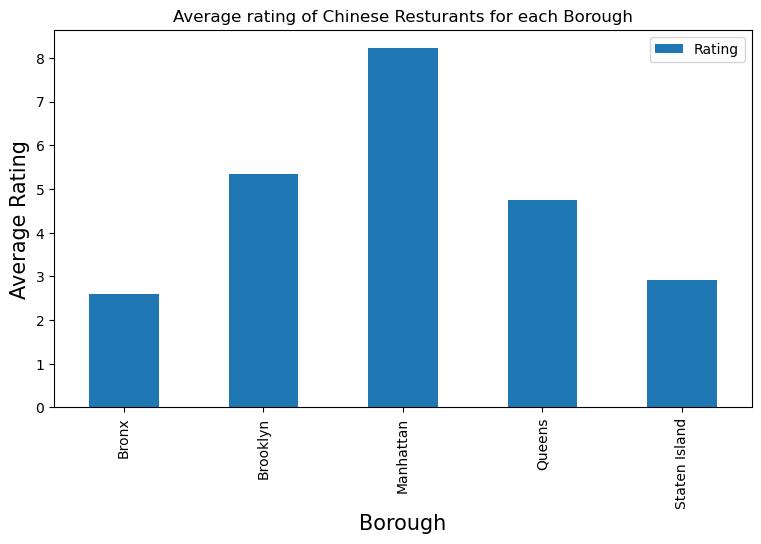

In [30]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Chinese Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
chinese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 8.0 to visualize on map

In [31]:
ny_neighborhood_stats_average=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

In [32]:
ny_neighborhood_stats_average

,Neighborhood,Average Rating
9,Bayswater,8.400000
17,Boerum Hill,8.300000
23,Brooklyn Heights,8.500000
31,Chelsea,8.800000
32,Chinatown,8.766667
35,Civic Center,8.600000
47,Downtown,8.400000
52,East Village,8.800000
96,Little Italy,8.766667
99,Lower East Side,8.700000


We will join this dataset to original new york data to get lonitude and latitude

In [33]:
ny_neighborhood_stats_fin=pd.merge(ny_neighborhood_stats_average,new_york_data, on='Neighborhood')
ny_neighborhood_stats_fin=ny_neighborhood_stats_fin[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats_fin

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Bayswater,40.611322,-73.765968,8.400000
1,Brooklyn,Boerum Hill,40.685683,-73.983748,8.300000
2,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.500000
3,Manhattan,Chelsea,40.744035,-74.003116,8.800000
4,Staten Island,Chelsea,40.594726,-74.189560,8.800000
5,Manhattan,Chinatown,40.715618,-73.994279,8.766667
6,Manhattan,Civic Center,40.715229,-74.005415,8.600000
7,Brooklyn,Downtown,40.690844,-73.983463,8.400000
8,Manhattan,East Village,40.727847,-73.982226,8.800000
9,Manhattan,Little Italy,40.719324,-73.997305,8.766667


Now we will show this data on a map

In [34]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [35]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats_fin[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose

In [36]:
ny_neighborhood_stats_fin['Label']=ny_neighborhood_stats_fin['Neighborhood']+', '+ny_neighborhood_stats_fin['Borough']+'('+ny_neighborhood_stats_fin['Average Rating'].map(str)+')'

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats_fin[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)